Ideas on how to merge data
First merge the data I have. do feature engineering later

**Features**

*Census* - monthly aggregated - should be easy to include an offset in a poisson regression
*Mag* - daily, will have a lot of nans, 
*SpaceWeather* - daily
*Winds* - daily
*Chlorophyll* - daily
*Tides* - daily

**Targets**

*Stranding* 
    - total
    - split by species

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from seaborn import heatmap
from matplotlib import rcParams
from cmocean import cm as cmo
from datetime import datetime as dt

In [3]:
%matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

#### <u>Stranding data</u>

In [5]:
dfStrand = pd.read_pickle('../PklJar/Data/dfStrandDailyCleanCompact.pkl')
dfStrand.rename(columns={'NUM_ANIMALS': 'Total_Stranded'},
                inplace=True)
dfStrand.columns = dfStrand.columns.str.replace('SPECIES', 'Stranded')
begin_date = dfStrand.index[0].to_pydatetime().strftime('%Y-%m-%d')
end_date = dfStrand.index[-1].to_pydatetime().strftime('%Y-%m-%d')

#### <u>Census data</u>

In [6]:
dfCensus = pd.read_pickle('../PklJar/Data/Census/dfCensus_Cape_Cod_6spp.pkl')
dfCensus = dfCensus.filter(regex='ount')
dfCensus.columns = dfCensus.columns.str.replace('count' ,'census')
dfCensus.rename(columns={'Sum_Counts': 'AllSpp_census'}, inplace=True)

In [7]:
# take rolling sum to account for possible presence of animals
# within the range equivalent to 1 week of cruising from stranding site
dfCensusWeeklyRollingSum = dfCensus.rolling('7D').sum()

In [8]:
dfCensusWeeklyRollingSum.describe().T

,count,mean,std,min,25%,50%,75%,max
Stene_census,5844.0,12.557837,82.916559,0.0,0.0,0.0,0.0,1348.0
Gramp_census,5844.0,5.306639,23.811753,0.0,0.0,0.0,0.0,365.0
Delph_census,5844.0,76.796030,254.405741,0.0,0.0,0.0,30.0,3010.0
Lagen_census,5844.0,86.090178,227.404227,0.0,0.0,3.0,60.0,2956.0
Tursi_census,5844.0,96.757871,240.473984,0.0,0.0,3.0,71.0,2473.0
Globi_census,5844.0,11.307324,30.357722,0.0,0.0,0.0,5.0,320.0
AllSpp_census,5844.0,288.815880,491.867365,0.0,8.0,84.0,346.5,3587.0


In [9]:
dfCensusWeeklyRollingSum = dfCensusWeeklyRollingSum.loc[begin_date: end_date]

In [10]:
# merge stranding and census data
dfMerged = dfStrand.merge(dfCensusWeeklyRollingSum, right_index=True,
                          left_index=True, how='outer')
dfMerged.head(2).T

REPORT_DATE,1999-03-07 00:00:00,1999-03-08 00:00:00
Total_Stranded,11.0,0.0
Stranded_Delphinus delphis,0.0,0.0
Stranded_Globicephala melas,0.0,0.0
Stranded_Grampus griseus,0.0,0.0
Stranded_Lagenorhynchus acutus,6.0,0.0
Stranded_Stenella coeruleoalba,0.0,0.0
Stranded_Tursiops truncatus,0.0,0.0
CONDITION_CODE_1,4.0,0.0
CONDITION_CODE_2,2.0,0.0
CONDITION_CODE_3,0.0,0.0


In [11]:
dfMerged.tail(2).T

REPORT_DATE,2014-12-03 00:00:00,2014-12-04 00:00:00
Total_Stranded,0.0,2.0
Stranded_Delphinus delphis,0.0,2.0
Stranded_Globicephala melas,0.0,0.0
Stranded_Grampus griseus,0.0,0.0
Stranded_Lagenorhynchus acutus,0.0,0.0
Stranded_Stenella coeruleoalba,0.0,0.0
Stranded_Tursiops truncatus,0.0,0.0
CONDITION_CODE_1,0.0,0.0
CONDITION_CODE_2,0.0,2.0
CONDITION_CODE_3,0.0,0.0


Splitting up features from labels and pickling both dataFrames:

In [12]:
dfFeatures = dfMerged.filter(regex='census', axis=1)
dfLabels = dfMerged.filter(regex='Stranded', axis=1)

In [13]:
dfFeatures.to_pickle('../PklJar/Data/DFFEATURES.pkl')
dfLabels.to_pickle('../PklJar/Data/DFLABELS.pkl')

#### <u>Frederick and Ottawa Magnetic Data</u>

In [14]:
# Pulling in Mag:
dfMag = pd.read_pickle('../PklJar/Data/dfMagDaily.pkl')
dfMag.columns = ['Mag_%s' %col for col in dfMag.columns]

In [15]:
dfMag = dfMag.loc[begin_date: end_date]
dfMag.head()

,Mag_FRDH,Mag_FRDV,Mag_OTTH,Mag_OTTV
DATE_TIME,,,,
1999-03-07,20973.912083,49185.560903,17437.979625,53532.025069
1999-03-08,20990.983472,49181.313264,17456.633064,53532.310625
1999-03-09,21094.763472,49251.502500,17449.245519,53528.842847
1999-03-10,20977.871806,49174.146944,17433.556173,53506.013542
1999-03-11,20882.766944,49104.043333,17456.700552,53524.094653


In [16]:
dfFeatures = dfFeatures.merge(dfMag, how='outer', left_index=True, right_index=True)

In [17]:
dfFeatures.head()

,Stene_census,Gramp_census,Delph_census,Lagen_census,Tursi_census,Globi_census,AllSpp_census,Mag_FRDH,Mag_FRDV,Mag_OTTH,Mag_OTTV
REPORT_DATE,,,,,,,,,,,
1999-03-07,0.0,0.0,0.0,102.0,0.0,0.0,102.0,20973.912083,49185.560903,17437.979625,53532.025069
1999-03-08,0.0,0.0,0.0,62.0,0.0,0.0,62.0,20990.983472,49181.313264,17456.633064,53532.310625
1999-03-09,0.0,14.0,350.0,62.0,30.0,0.0,456.0,21094.763472,49251.502500,17449.245519,53528.842847
1999-03-10,0.0,14.0,350.0,22.0,30.0,0.0,416.0,20977.871806,49174.146944,17433.556173,53506.013542
1999-03-11,0.0,14.0,350.0,72.0,30.0,0.0,466.0,20882.766944,49104.043333,17456.700552,53524.094653


In [18]:
dfFeatures.to_pickle('../PklJar/DFFEATURES.pkl')

#### <u>Space Weather</u>

In [19]:
# Pulling in SpaceWeather
dfSW = pd.read_pickle('../PklJar/Data/dfSpaceWeatherDaily.pkl')
dfSW = dfSW.loc[begin_date: end_date]

In [20]:
dfFeatures = dfFeatures.merge(dfSW, how='outer',
                              left_index=True, right_index=True)

In [21]:
dfFeatures.head(2).T

REPORT_DATE,1999-03-07 00:00:00,1999-03-08 00:00:00
Stene_census,0.000000,0.000000
Gramp_census,0.000000,0.000000
Delph_census,0.000000,0.000000
Lagen_census,102.000000,62.000000
Tursi_census,0.000000,0.000000
Globi_census,0.000000,0.000000
AllSpp_census,102.000000,62.000000
Mag_FRDH,20973.912083,20990.983472
Mag_FRDV,49185.560903,49181.313264
Mag_OTTH,17437.979625,17456.633064


In [22]:
dfFeatures.to_pickle('../PklJar/Data/DFFEATURES.pkl')

#### Tidal Data

In [23]:
dfTides = pd.read_pickle('../PklJar/Data/dfTidesDaily.pkl')
dfTides = dfTides.loc[begin_date: end_date]
dfTides = dfTides.filter(regex='Pred_m')

In [24]:
dfTides.head(2).T

Date_Time,1999-03-07 00:00:00,1999-03-08 00:00:00
Pred_min,0.150,0.24
Pred_max,2.860,2.79
Pred_med,1.495,1.49


In [25]:
dfFeatures = dfFeatures.merge(dfTides, 'outer', left_index=True, right_index=True)

In [26]:
dfFeatures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 1999-03-07 to 2014-12-04
Freq: D
Data columns (total 20 columns):
Stene_census           5752 non-null float64
Gramp_census           5752 non-null float64
Delph_census           5752 non-null float64
Lagen_census           5752 non-null float64
Tursi_census           5752 non-null float64
Globi_census           5752 non-null float64
AllSpp_census          5752 non-null float64
Mag_FRDH               5744 non-null float64
Mag_FRDV               5732 non-null float64
Mag_OTTH               5414 non-null float64
Mag_OTTV               5400 non-null float64
Kp_index               5752 non-null float64
Sunspot_No             5752 non-null float64
Dst_index              5752 non-null float64
AE_index               5752 non-null float64
Proton_flux_gt30MeV    5260 non-null float64
Proton_flux_gt60MeV    5260 non-null float64
Pred_min               5752 non-null float64
Pred_max               5752 non-null float64
Pred_med    

In [27]:
dfFeatures.to_pickle('../PklJar/Data/DFFEATURES.pkl')

#### <u>Wind Data</u>

In [28]:
dfWind = pd.read_pickle('../PklJar/Data/dfDailyWind.pkl')
dfWind = dfWind.loc[begin_date: end_date]

In [29]:
dfFeatures = dfFeatures.merge(dfWind, 'outer', left_index=True, right_index=True)

In [30]:
dfFeatures.head(2).T

REPORT_DATE,1999-03-07 00:00:00,1999-03-08 00:00:00
Stene_census,0.000000,0.000000
Gramp_census,0.000000,0.000000
Delph_census,0.000000,0.000000
Lagen_census,102.000000,62.000000
Tursi_census,0.000000,0.000000
Globi_census,0.000000,0.000000
AllSpp_census,102.000000,62.000000
Mag_FRDH,20973.912083,20990.983472
Mag_FRDV,49185.560903,49181.313264
Mag_OTTH,17437.979625,17456.633064


In [31]:
dfFeatures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 1999-03-07 to 2014-12-04
Freq: D
Data columns (total 26 columns):
Stene_census           5752 non-null float64
Gramp_census           5752 non-null float64
Delph_census           5752 non-null float64
Lagen_census           5752 non-null float64
Tursi_census           5752 non-null float64
Globi_census           5752 non-null float64
AllSpp_census          5752 non-null float64
Mag_FRDH               5744 non-null float64
Mag_FRDV               5732 non-null float64
Mag_OTTH               5414 non-null float64
Mag_OTTV               5400 non-null float64
Kp_index               5752 non-null float64
Sunspot_No             5752 non-null float64
Dst_index              5752 non-null float64
AE_index               5752 non-null float64
Proton_flux_gt30MeV    5260 non-null float64
Proton_flux_gt60MeV    5260 non-null float64
Pred_min               5752 non-null float64
Pred_max               5752 non-null float64
Pred_med    

In [32]:
dfFeatures.to_pickle('../PklJar/Data/DFFEATURES.pkl')

Inspect Pairwise Correlation among predictors

In [33]:
dfCorr = dfFeatures.corr()

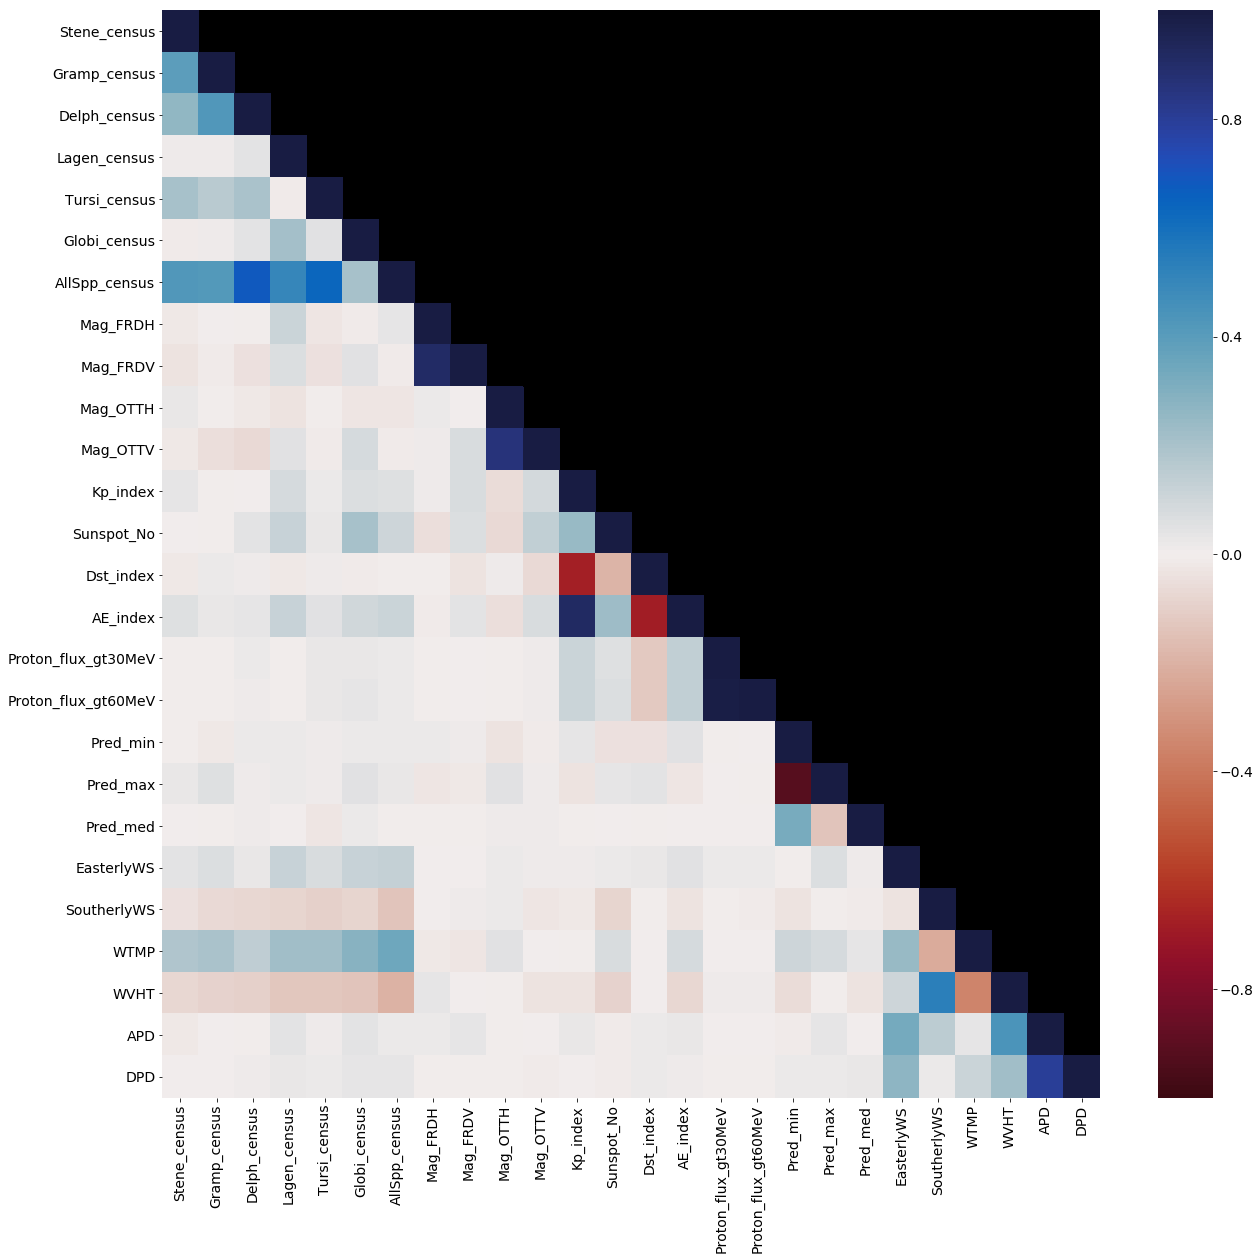

In [34]:
f, ax = pl.subplots(figsize=(21, 20))
ax.set_facecolor('black')
heatmap(dfCorr, ax=ax, vmin=-1, vmax=1, mask=np.triu(np.ones([dfCorr.shape[1]]*2), k=1),
       cmap=cmo.balance_r)